## 0. Import

In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import nbinom, poisson, binom,norm
import pymc as pm
import arviz as az
from Bio import Phylo
from tqdm.notebook import tqdm
import scipy.stats as st
from matplotlib.backends.backend_pdf import PdfPages
import re
import pickle

# 1.CRC--Filtering based on mutation number distribution (NegativeBinomial distribution)

## 1. Filtering based on mutation number distribution (NegativeBinomial distribution)

### 1.1 CRC & Apc samples (Two distributions)
Tumor cells of these four mice are well splitted using two NegativeBinomial distribution

In [37]:
PHYDIR="/data2/kantian/LineageTracing/SMALT/0.Results/1.N2T2/"
OUTDIR="/data2/kantian/LineageTracing/SMALT/0.Results/2.filteredNT/"

if not os.path.exists(OUTDIR):
    os.mkdir(OUTDIR)
# paras = dict()
samples = ["4_T","5_T","16_T","19_T3","19_T4","47_T1","47_T5","49_T1","49_T3","65_T1","142_T1","132_T1","18_T3","148_T3",
           "68_P5-1","68_P5-5"]
# pp = PdfPages('/data2/kantian/LineageTracing/SMALT/0.Results/figures/1.1.dist_split_CRC_density_plot.pdf')
# for mySample in samples:
for mySample in ['132_T1']:
    print("Calculating "+mySample+"...")
    phy = pd.read_csv(PHYDIR+mySample+"_N2T2.phy",sep = " ",header = None,skiprows=[0,1], names = ["nam","bi"],index_col = 0)
    phy["numMut"] = [phy['bi'][i].count("1") for i in range(len(phy.index))]

    ## be cautious!!! Some samples were broken with less than 3004 sites
    numSite=len(phy["bi"][0])
    print(numSite)
    ##
    phy["type"] = [i[0] for i in phy.index]
    print(phy["type"].value_counts())
    nt = phy[phy['type']!='N'].iloc[:,1].to_numpy()
    n = phy[phy['type']=='N'].iloc[:,1].to_numpy()
    # Since mutation numbers >=2, to enable fitting the model, values -2. The final cutoff value will add 2 back.
    n = n - 2
    nt = nt - 2
    mu1_mu = np.mean(n)
    mu2_mu = np.mean(nt)

    """
    Mixture of 2 Poisson variables
    """
    with pm.Model() as model:
        w = pm.Dirichlet('w', a=np.array([1, 1]))  # 2 mixture weights

        # lam1 = pm.Exponential('lam1', lam=1)
        # lam2 = pm.Exponential('lam2', lam=1)

        mu1 = pm.Normal('mu1', mu=mu1_mu, sigma=1)
        mu2 = pm.Normal('mu2', mu=mu2_mu, sigma=1)
        alpha1 = pm.Exponential('alpha1', lam=1)
        alpha2 = pm.Exponential('alpha2', lam=1)

        # As we just need the logp, rather than add a RV to the model, we need to call `.dist()`
        # These two forms are equivalent, but the second benefits from vectorization
        components = [
            pm.NegativeBinomial.dist(mu=mu1, alpha=alpha1),
            pm.NegativeBinomial.dist(mu=mu2, alpha=alpha2),
        ]
        # `shape=(2,)` indicates 2 mixture components
        # components = pm.NegativeBinomial.dist(mu=pm.math.stack([mu1, mu2], n=pm.math.stack([alpha1, alpha2])), shape=(2,))

        like = pm.Mixture('like', w=w, comp_dists=components, observed=nt)

    with model:
        idata = pm.sample(draws = 500, tune= 500)
#     """plot 1
#     """
#     fig, ax = plt.subplots(5, 2, figsize=(10, 8))
#     az.plot_trace(idata, axes=ax)
#     plt.suptitle("Mouse #"+mySample)
#     plt.tight_layout()
    
# #     az.plot_trace(idata)
# #     plt.tight_layout()
#     pp.savefig(plt.gcf())
    """plot mean
    """
    mu1 = idata.posterior['mu1'].values.mean()
    mu2 = idata.posterior['mu2'].values.mean()
    alpha1 = idata.posterior['alpha1'].values.mean()
    alpha2 = idata.posterior['alpha2'].values.mean()
    w1, w2 = idata.posterior['w'].values.mean(axis=1).mean(axis=0)
    print(f'{mySample=},{mu1=},{mu2=},{alpha1=},{alpha2=},{w1=},{w2=}')
    paras[mySample] = [mu1, mu2, alpha1, alpha2, w1, w2]
    pickle.dump(idata, open(f'./temp/{mySample}', 'wb'))
    # """plot 2
    # """
#     figure, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
    
#     sns.histplot(nt, stat='density', alpha=0.3,ax=ax[0])
#     dist1 = w1*nbinom(*pm.NegativeBinomial.get_n_p(mu1, alpha1)).pmf(np.arange(100))
#     dist2 = w2*nbinom(*pm.NegativeBinomial.get_n_p(mu2, alpha2)).pmf(np.arange(100))
#     ax[0].plot(dist1, c='tab:green', lw=5)
#     ax[0].fill_between(dist1, 0, color = 'tab:green', alpha=0.1)
#     ax[0].plot(dist2, c='tab:blue', lw=5)
#     ax[0].fill_between(dist1, 0, color = 'tab:blue', alpha=0.1)
#     ax[0].plot(dist1+dist2, c='tab:orange', lw=5)
#     ax[0].set_title(mySample+"Mixture of two Negative Binomial distribution", fontsize=12)
# #     pp.savefig(plt.gcf())
#     cutoff = np.arange(100)[dist1<dist2][0]
    print("N&T cutoff ",cutoff+2)
    # break
# pp.close()  





Calculating 132_T1...


/tmp/ipykernel_236323/3490764994.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  phy["numMut"] = [phy['bi'][i].count("1") for i in range(len(phy.index))]
/tmp/ipykernel_236323/3490764994.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numSite=len(phy["bi"][0])


3004
type
T    3694
N    1596
Name: count, dtype: int64


/home/kantian/miniconda3/envs/smalt/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1028: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/kantian/miniconda3/envs/smalt/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1028: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, mu1, mu2, alpha1, alpha2]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 672 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


mySample='132_T1',mu1=4.127801446820038,mu2=42.354954208004685,alpha1=0.6248999583625093,alpha2=3.101503190418348,w1=0.2020902942118296,w2=0.7979097057881703
N&T cutoff  29


Text(0.5, 1.0, '4_TMixture of two Negative Binomial distribution')

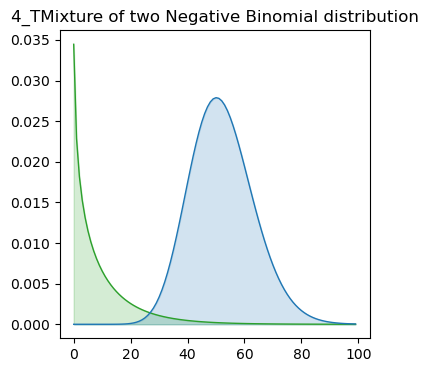

In [28]:
figure, ax = plt.subplots(figsize=(4,4))

# sns.histplot(nt, stat='density', alpha=0.3,ax=ax)
dist1 = w1*nbinom(*pm.NegativeBinomial.get_n_p(mu1, alpha1)).pmf(np.arange(100))
dist2 = w2*nbinom(*pm.NegativeBinomial.get_n_p(mu2, alpha2)).pmf(np.arange(100))
ax.plot(dist1, c='tab:green', lw=1)
ax.fill_between(np.arange(100), dist1, np.zeros_like(dist1), color = 'tab:green', alpha=0.2)
ax.plot(dist2, c='tab:blue', lw=1)
ax.fill_between(np.arange(100), dist2, np.zeros_like(dist2), color = 'tab:blue', alpha=0.2)
ax.set_title(mySample+"Mixture of two Negative Binomial distribution", fontsize=12)

In [68]:
plt.rcParams['font.size']=10

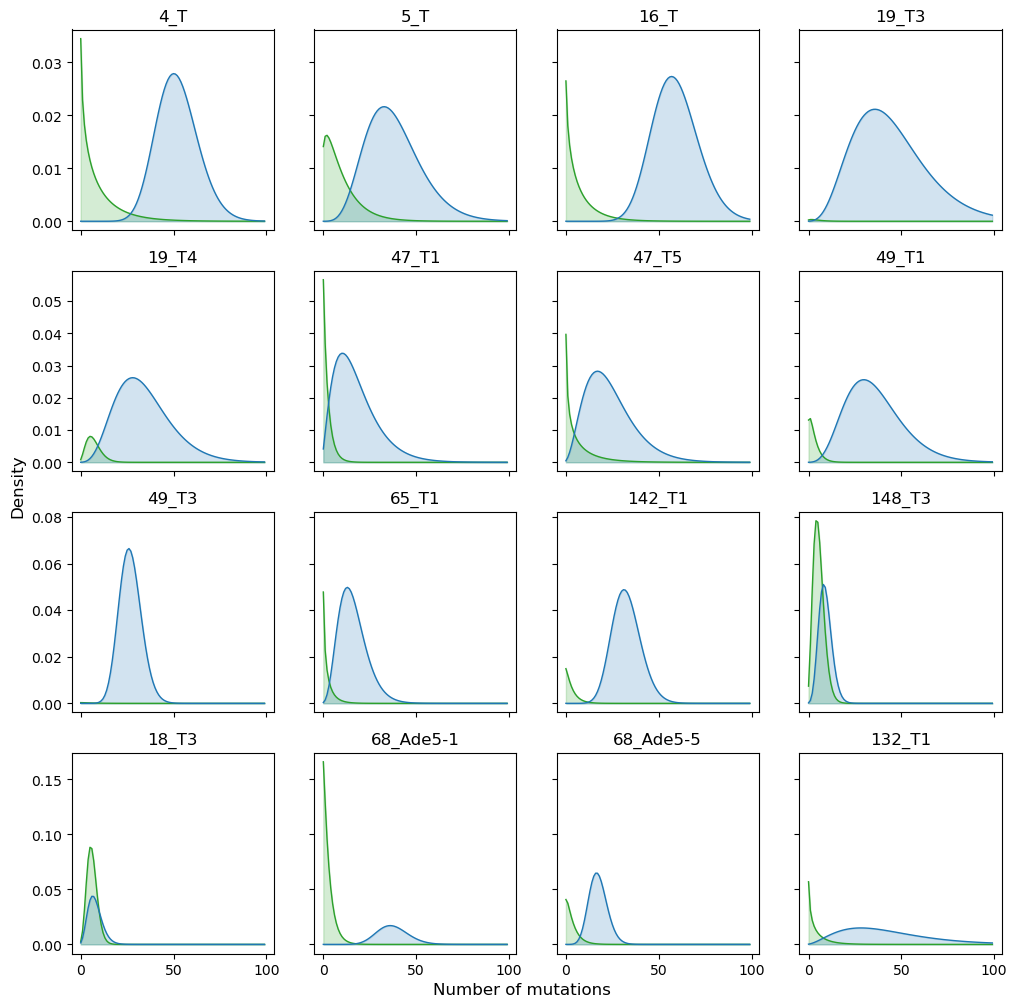

In [83]:

plt.rcParams['pdf.fonttype'] = 42

paras = pickle.load(open('./temp/nb_mix_paras_mu1, mu2, alpha1, alpha2, w1, w2.pkl', 'rb'))
fig, ax = plt.subplots(4,4, figsize=(12, 12), sharex='col', sharey='row')
for ind, samp in enumerate(paras.keys()):
    mu1, mu2, alpha1, alpha2, w1, w2 = paras[samp]
    dist1 = w1*nbinom(*pm.NegativeBinomial.get_n_p(mu1, alpha1)).pmf(np.arange(100))
    dist2 = w2*nbinom(*pm.NegativeBinomial.get_n_p(mu2, alpha2)).pmf(np.arange(100))
    ax[ind//4][ind%4].plot(dist1, c='tab:green', lw=1)
    ax[ind//4][ind%4].fill_between(np.arange(100), dist1, np.zeros_like(dist1), color = 'tab:green', alpha=0.2)
    ax[ind//4][ind%4].plot(dist2, c='tab:blue', lw=1)
    ax[ind//4][ind%4].fill_between(np.arange(100), dist2, np.zeros_like(dist2), color = 'tab:blue', alpha=0.2)
    ax[ind//4][ind%4].set_title(samp, fontsize=12)
# plt.tight_layout()
fig.text(0.5, 0.08, 'Number of mutations', ha='center', va='center',fontsize=12)
fig.text(0.08, 0.5, 'Density', ha='center', va='center', rotation='vertical',fontsize=12)

plt.savefig("/data2/kantian/LineageTracing/SMALT/0.Results/figures/1.1.dist_split_plot_all.pdf",format="pdf",bbox_inches="tight")


In [77]:
paras['19_T3']

[4.7096017729713315,
 44.64402019732545,
 1.80130976907909,
 5.321396803001831,
 0.0024776513767150055,
 0.9975223486232853]